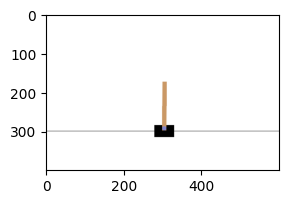

In [1]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('CartPole-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        over = terminated or truncated

        #限制最大步数
        self.step_n += 1
        if self.step_n >= 200:
            over = True
        
        #没坚持到最后,扣分
        if over and self.step_n < 200:
            reward = -1000

        return state, reward, over

    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()


env = MyWrapper()

env.reset()

env.show()

In [2]:
import torch

#定义模型,计算每个动作的概率
model = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2),
    torch.nn.Softmax(dim=1),
)

model

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=2, bias=True)
  (5): Softmax(dim=1)
)

In [4]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
    state = []
    action = []
    reward = []

    s = env.reset()
    o = False
    while not o:
        #根据概率采样
        prob = model(torch.FloatTensor(s).reshape(1, 4))[0].tolist()
        a = random.choices(range(2), weights=prob, k=1)[0]

        ns, r, o = env.step(a)

        state.append(s)
        action.append(a)
        reward.append(r)

        s = ns

        if show:
            display.clear_output(wait=True)
            env.show()

    state = torch.FloatTensor(state).reshape(-1, 4)
    action = torch.LongTensor(action).reshape(-1, 1)
    reward = torch.FloatTensor(reward).reshape(-1, 1)

    return state, action, reward, reward.sum().item()


state, action, reward, reward_sum = play()

reward_sum

-991.0

In [ ]:
'''
* 作用: 這是整個 Notebook 的核心，幾乎所有的改動都在這裡。
* 步驟分解:
    1. 玩遊戲並計算未來獎勵 (`value`): 這部分和之前一樣，通過 play() 收集數據，然後用蒙地卡羅法計算每一步的未來總折扣獎勵 value。
    2. 計算策略梯度損失 (`loss`): loss = -((prob + 1e-8).log() * value).mean() 這部分也和 01_reinforce.ipynb 一樣，是 REINFORCE
        演算法的標準損失。
    3. 計算熵 (`entropy`) - ✨ 核心新增部分 ✨:
        * entropy = prob * (prob + 1e-8).log()
        * entropy = -entropy.mean()
        * 這是什麼？ 熵 (Entropy) 在這裡衡量的是模型輸出機率的「不確定性」或「隨機性」。
            * 如果模型非常確定地輸出 [0.99, 0.01]，那麼熵就很低。
            * 如果模型非常不確定，輸出 [0.5, 0.5]，那麼熵就很高。
        * 為什麼要計算它？ 我們希望在訓練初期，模型能多方嘗試，不要太快就認定某個動作是唯一解。高熵代表著更多的探索。
    4. 組合最終的 Loss:
        * loss -= entropy * 5
        * 為什麼是減去？ 優化器的目標是最小化 loss。我們希望最大化 entropy 來鼓勵探索。因此，在 loss
            中減去一個正的熵值，就等於給了模型一個「保持探索的獎勵」。如果模型變得太確定（熵變低），loss 就會相應地變大，促使模型調整。
        * `* 5` 是什麼？ 這是一個超參數，用來控制「熵獎勵」的強度。這個值越大，模型就越傾向於探索，而不是單純地利用當前學到的最好策略。
    5. 更新模型: 和之前一樣，反向傳播這個新的、包含了熵的 loss，並更新模型。
'''

#训练
def train():
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

    #训练N局
    for epoch in range(1000):

        #一个epoch最少玩N步
        steps = 0
        while steps < 200:

            #玩一局游戏,得到数据
            state, action, reward, _ = play()
            steps += len(state)

            #计算当前state的价值,其实就是Q(state,action),这里是用蒙特卡洛法估计的
            value = []
            for i in range(len(reward)):
                s = 0
                for j in range(i, len(reward)):
                    s += reward[j] * 0.99**(j - i)
                value.append(s)
            value = torch.FloatTensor(value).reshape(-1, 1)

            #重新计算动作的概率
            prob = model(state).gather(dim=1, index=action)

            #求Q最大的导函数 -> partial value / partial action
            loss = (prob + 1e-8).log() * value
            for i in range(len(loss)):
                loss[i] = loss[i] * 0.99**i
            loss = -loss.mean()

            #计算动作的熵,越大越好
            entropy = prob * (prob + 1e-8).log()
            entropy = -entropy.mean()
            loss -= entropy * 5

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        if epoch % 100 == 0:
            test_result = sum([play()[-1] for _ in range(20)]) / 20
            print(epoch, loss.item(), entropy.item(), test_result)


train()

0 -388.1980285644531 0.2756229639053345 -981.85
100 15.156693458557129 0.24505282938480377 200.0
200 15.299684524536133 0.2427700012922287 200.0
300 15.468460083007812 0.25265729427337646 200.0
400 15.639886856079102 0.2508995532989502 200.0
500 15.48071575164795 0.24205730855464935 200.0
600 15.425715446472168 0.2603299617767334 200.0
700 16.414133071899414 0.23550617694854736 200.0
800 16.502761840820312 0.22870565950870514 200.0
900 15.617315292358398 0.23415404558181763 200.0


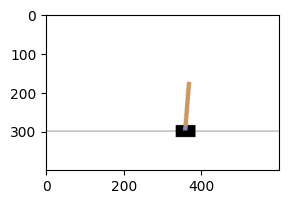

200.0

In [6]:
play(True)[-1]